In [26]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns

In [3]:
features = pd.read_parquet('../features/processed/features.parquet')
features.head()

,pdv_codigo,fecha_comercial,codigo_barras_sku,nombre_sku,imp_vta,cant_vta,stock,year,month,day,day_of_week,is_weekend,quarter,week_of_year,day_of_year,is_month_start,is_month_end,is_first_week,is_last_week,cluster,cluster_sku
0,1,2022-12-23,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,33.96,2400.0,NaN,2022,12,23,4,0,4,51,357,0,0,0,0,1,1
1,1,2022-12-24,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,59.43,4200.0,NaN,2022,12,24,5,1,4,51,358,0,0,0,0,1,1
2,1,2022-12-27,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,8.49,600.0,NaN,2022,12,27,1,0,4,52,361,0,0,0,1,1,1
3,1,2022-12-30,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,42.45,3000.0,NaN,2022,12,30,4,0,4,52,364,0,0,0,1,1,1
4,1,2022-12-31,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,110.37,7800.0,NaN,2022,12,31,5,1,4,52,365,0,1,0,1,1,1


In [14]:
codigo_barras_to_drop = [7891991006200, 7896045500116, 7896045512348, 7896045506101]
rows_to_drop = features[(features['pdv_codigo'] == 17) & (features['codigo_barras_sku'].isin(codigo_barras_to_drop))].index
features = features.drop(rows_to_drop)
features.shape

(3172744, 21)

# pdv_codigo/codigo_barras_sku clusters

### Creating features for clustering

In [5]:
import pandas as pd

all_metrics = pd.DataFrame()

for year in features['year'].unique():
    year_data = features[features['year'] == year]
    
    # Metrics by year
    yearly_metrics = year_data.groupby(['pdv_codigo', 'codigo_barras_sku'])['cant_vta'].agg(
        # total_sales='sum',
        mean_sales='mean',
        # sales_std='std',
        # max_sales='max',
        # min_sales='min',
        # zero_sales_days=lambda x: (x == 0).sum(),
        # non_zero_sales_ratio=lambda x: (x > 0).mean()
    ).reset_index()
    yearly_metrics = yearly_metrics.rename(columns=lambda col: f'{year}_year_{col}' if col not in ['pdv_codigo', 'codigo_barras_sku'] else col)
    
    # Metrics by quarter
    quarterly_metrics = year_data.groupby(['pdv_codigo', 'codigo_barras_sku', 'quarter'])['cant_vta'].agg(
        # total_sales='sum',
        mean_sales='mean',
        # sales_std='std',
        # max_sales='max',
        # min_sales='min',
        # zero_sales_days=lambda x: (x == 0).sum(),
        non_zero_sales_ratio=lambda x: (x > 0).mean()
    ).unstack('quarter', fill_value=0)
    quarterly_metrics.columns = [f'{year}_Q_{q}_{metric}' for q, metric in quarterly_metrics.columns]
    quarterly_metrics.reset_index(inplace=True)
    
    # # Metrics by month
    # monthly_metrics = year_data.groupby(['pdv_codigo', 'codigo_barras_sku', 'month'])['cant_vta'].agg(
    #     # total_sales='sum',
    #     mean_sales='mean',
    #     # sales_std='std',
    #     # max_sales='max',
    #     # min_sales='min',
    #     # zero_sales_days=lambda x: (x == 0).sum(),
    #     # non_zero_sales_ratio=lambda x: (x > 0).mean()
    # ).unstack('month', fill_value=0)
    # monthly_metrics.columns = [f'{year}_M_{m}_{metric}' for m, metric in monthly_metrics.columns]
    # monthly_metrics.reset_index(inplace=True)
    
    combined_metrics = yearly_metrics.merge(quarterly_metrics, on=['pdv_codigo', 'codigo_barras_sku'], how='outer')
    # combined_metrics = combined_metrics.merge(monthly_metrics, on=['pdv_codigo', 'codigo_barras_sku'], how='outer')

    combined_metrics = combined_metrics.apply(lambda x: x.round(1) if x.dtype == 'float64' else x)
    

    if all_metrics.empty:
        all_metrics = combined_metrics
    else:
        all_metrics = all_metrics.merge(combined_metrics, on=['pdv_codigo', 'codigo_barras_sku'], how='outer')


In [6]:
all_metrics.head()

,pdv_codigo,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2022_Q_non_zero_sales_ratio_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2023_Q_non_zero_sales_ratio_1,2023_Q_non_zero_sales_ratio_2,2023_Q_non_zero_sales_ratio_3,2023_Q_non_zero_sales_ratio_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4,2024_Q_non_zero_sales_ratio_1,2024_Q_non_zero_sales_ratio_2,2024_Q_non_zero_sales_ratio_3,2024_Q_non_zero_sales_ratio_4
0,1,78905351,3600.0,3600.0,1.0,2567.8,1632.0,3600.0,2400.0,2491.3,1.0,1.0,1.0,1.0,2645.5,2680.0,2502.9,2500.0,3000.0,1.0,1.0,1.0,1.0
1,1,78905498,5462.1,5462.1,1.0,6067.6,6900.0,5716.7,5767.3,5640.0,1.0,1.0,1.0,1.0,3762.2,3720.0,3771.4,4000.0,3463.6,1.0,1.0,1.0,1.0
2,1,78908901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6623.5,0.0,0.0,0.0,6623.5,0.0,0.0,0.0,1.0
3,1,78909045,11566.7,11566.7,1.0,9538.0,12373.6,8667.6,8747.3,8422.2,1.0,1.0,1.0,1.0,9129.6,7332.4,5395.0,13321.0,0.0,1.0,1.0,1.0,0.0
4,1,78912939,16108.3,16108.3,1.0,12593.0,17778.1,10489.0,10472.8,11769.2,1.0,1.0,1.0,1.0,8363.9,8378.5,5724.4,9827.2,8562.5,1.0,1.0,1.0,1.0


In [8]:
all_metrics = all_metrics[['codigo_barras_sku', 
 'pdv_codigo',                          
# '2022_year_mean_sales', 
# '2022_Q_mean_sales_4',
# '2023_year_mean_sales',
# '2023_Q_mean_sales_1', 
# '2023_Q_mean_sales_2', 
# '2023_Q_mean_sales_3',
# '2023_Q_mean_sales_4', 
# '2024_year_mean_sales',
# '2024_Q_mean_sales_1', 
'2024_Q_mean_sales_2', 
'2024_Q_mean_sales_3',
'2024_Q_mean_sales_4'
]]
all_metrics

,codigo_barras_sku,pdv_codigo,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4
0,78905351,1,2502.9,2500.0,3000.0
1,78905498,1,3771.4,4000.0,3463.6
2,78908901,1,0.0,0.0,6623.5
3,78909045,1,5395.0,13321.0,0.0
4,78912939,1,5724.4,9827.2,8562.5
...,...,...,...,...,...
11475,8412598000478,30,2145.0,1425.0,907.5
11476,8412598003370,30,1980.0,0.0,0.0
11477,8712000025649,30,11704.5,18333.3,19027.8
11478,17898915949190,30,0.0,0.0,0.0


In [9]:
columns_to_check = [
    '2024_Q_mean_sales_2',    
    '2024_Q_mean_sales_3', 
    '2024_Q_mean_sales_4']


# Check for 0 or NaN values
mask = (all_metrics[columns_to_check] == 0) | (all_metrics[columns_to_check].isna())

rows_to_remove = mask.any(axis=1)
all_metrics = all_metrics[~rows_to_remove] 
all_metrics

,codigo_barras_sku,pdv_codigo,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4
0,78905351,1,2502.9,2500.0,3000.0
1,78905498,1,3771.4,4000.0,3463.6
4,78912939,1,5724.4,9827.2,8562.5
6,78934115,1,1051.1,1178.6,660.0
7,78935495,1,1628.0,1179.5,4535.7
...,...,...,...,...,...
11466,7898925943709,30,1686.5,1272.0,2075.0
11467,7898953990065,30,1435.0,6094.1,1400.0
11470,7898953990157,30,946.0,709.5,946.0
11475,8412598000478,30,2145.0,1425.0,907.5


In [10]:
filter = all_metrics[['codigo_barras_sku','pdv_codigo']].drop_duplicates()
filter 

,codigo_barras_sku,pdv_codigo
0,78905351,1
1,78905498,1
4,78912939,1
6,78934115,1
7,78935495,1
...,...,...
11466,7898925943709,30
11467,7898953990065,30
11470,7898953990157,30
11475,8412598000478,30


In [11]:
features = features.merge(filter, on=['codigo_barras_sku', 'pdv_codigo'], how='inner')
features


,pdv_codigo,fecha_comercial,codigo_barras_sku,nombre_sku,imp_vta,cant_vta,stock,year,month,day,day_of_week,is_weekend,quarter,week_of_year,day_of_year,is_month_start,is_month_end,is_first_week,is_last_week,cluster,cluster_sku
0,1,2022-12-23,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,33.96,2400.0,NaN,2022,12,23,4,0,4,51,357,0,0,0,0,1,1
1,1,2022-12-24,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,59.43,4200.0,NaN,2022,12,24,5,1,4,51,358,0,0,0,0,1,1
2,1,2022-12-27,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,8.49,600.0,NaN,2022,12,27,1,0,4,52,361,0,0,0,1,1,1
3,1,2022-12-30,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,42.45,3000.0,NaN,2022,12,30,4,0,4,52,364,0,0,0,1,1,1
4,1,2022-12-31,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,110.37,7800.0,NaN,2022,12,31,5,1,4,52,365,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3172739,30,2024-12-02,8712000025649,CERVEJA HEINEKEN BARRIL METALICO 5L,107.90,5000.0,161.0,2024,12,2,0,0,4,49,337,0,0,1,0,1,0
3172740,30,2024-12-06,8712000025649,CERVEJA HEINEKEN BARRIL METALICO 5L,215.80,10000.0,161.0,2024,12,6,4,0,4,49,341,0,0,1,0,1,0
3172741,30,2024-12-07,8712000025649,CERVEJA HEINEKEN BARRIL METALICO 5L,4314.60,270000.0,159.0,2024,12,7,5,1,4,49,342,0,0,1,0,1,0
3172742,30,2024-12-08,8712000025649,CERVEJA HEINEKEN BARRIL METALICO 5L,375.60,20000.0,101.0,2024,12,8,6,1,4,49,343,0,0,0,0,1,0


In [12]:
features.to_parquet('../features/processed/features.parquet')

### Applying KMeans clustering

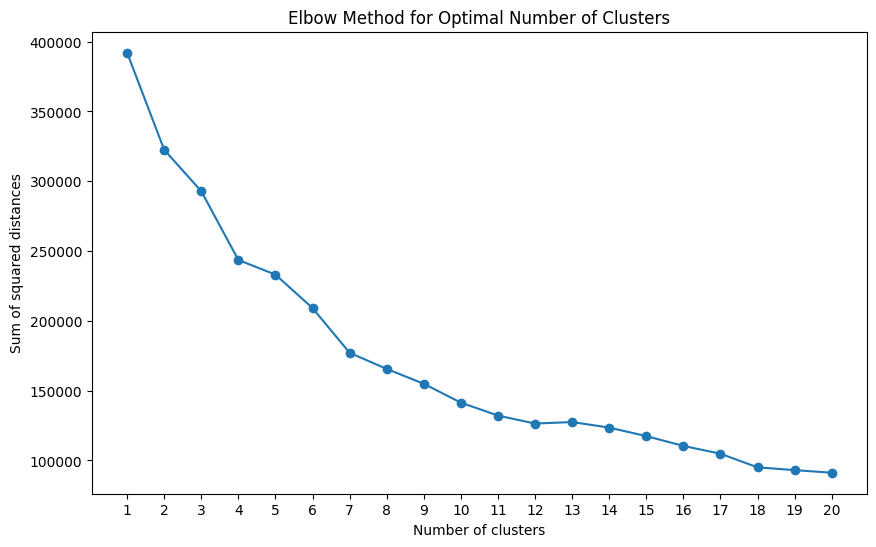

In [6]:
clustering_features = all_metrics.drop(columns=['pdv_codigo', 'codigo_barras_sku'])

# Handle missing values by filling with 0
clustering_features = clustering_features.fillna(0)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Elbow method to determine the ideal number of clusters
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, 21)) 
plt.show()


In [7]:
# Apply K-Means clustering with 8 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
all_metrics['cluster'] = kmeans.fit_predict(scaled_features)

all_metrics['cluster'].value_counts()

cluster
1    8647
0    4980
2    4926
3     116
Name: count, dtype: int64

In [8]:
cluster_means = all_metrics.groupby('cluster').mean()
cluster_means


,pdv_codigo,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2022_Q_non_zero_sales_ratio_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2023_Q_non_zero_sales_ratio_1,2023_Q_non_zero_sales_ratio_2,2023_Q_non_zero_sales_ratio_3,2023_Q_non_zero_sales_ratio_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4,2024_Q_non_zero_sales_ratio_1,2024_Q_non_zero_sales_ratio_2,2024_Q_non_zero_sales_ratio_3,2024_Q_non_zero_sales_ratio_4
cluster,,,,,,,,,,,,,,,,,,,,,,,
0,15.258434,7.772165e+12,5396.132467,5396.132467,1.0,4392.882927,3417.969344,3754.805530,2464.974769,1667.142115,0.850715,0.809294,0.619218,0.301514,3280.823916,2174.799021,425.640559,760.684895,645.645734,0.606993,0.128671,0.244755,0.274126
1,15.179369,7.577427e+12,13449.857078,13449.857078,1.0,9592.429374,8696.860079,8651.827628,8897.163317,11415.978397,0.954435,0.984503,0.976986,0.963224,9719.881878,9722.969805,9140.413242,9323.264936,9270.051740,0.966578,0.983925,0.949231,0.886435
2,16.194478,7.929852e+12,4125.522556,4125.522556,1.0,13307.867063,350.620557,430.950891,9148.637963,10776.275468,0.074006,0.094564,0.604842,0.771585,14019.315670,6612.395924,10538.725498,10678.295448,12617.570743,0.459239,0.655344,0.699275,0.743886
3,16.155172,8.170769e+12,351349.109333,351349.109333,1.0,658644.878095,241992.620952,288591.507619,461819.659048,729339.196190,0.857143,0.857143,0.961905,0.971429,540708.475676,398432.689189,343973.854955,351163.263063,474079.230631,0.891892,0.936937,0.936937,0.882883


In [9]:
cluster_means.columns

Index(['pdv_codigo', 'codigo_barras_sku', '2022_year_mean_sales',
       '2022_Q_mean_sales_4', '2022_Q_non_zero_sales_ratio_4',
       '2023_year_mean_sales', '2023_Q_mean_sales_1', '2023_Q_mean_sales_2',
       '2023_Q_mean_sales_3', '2023_Q_mean_sales_4',
       '2023_Q_non_zero_sales_ratio_1', '2023_Q_non_zero_sales_ratio_2',
       '2023_Q_non_zero_sales_ratio_3', '2023_Q_non_zero_sales_ratio_4',
       '2024_year_mean_sales', '2024_Q_mean_sales_1', '2024_Q_mean_sales_2',
       '2024_Q_mean_sales_3', '2024_Q_mean_sales_4',
       '2024_Q_non_zero_sales_ratio_1', '2024_Q_non_zero_sales_ratio_2',
       '2024_Q_non_zero_sales_ratio_3', '2024_Q_non_zero_sales_ratio_4'],
      dtype='object')

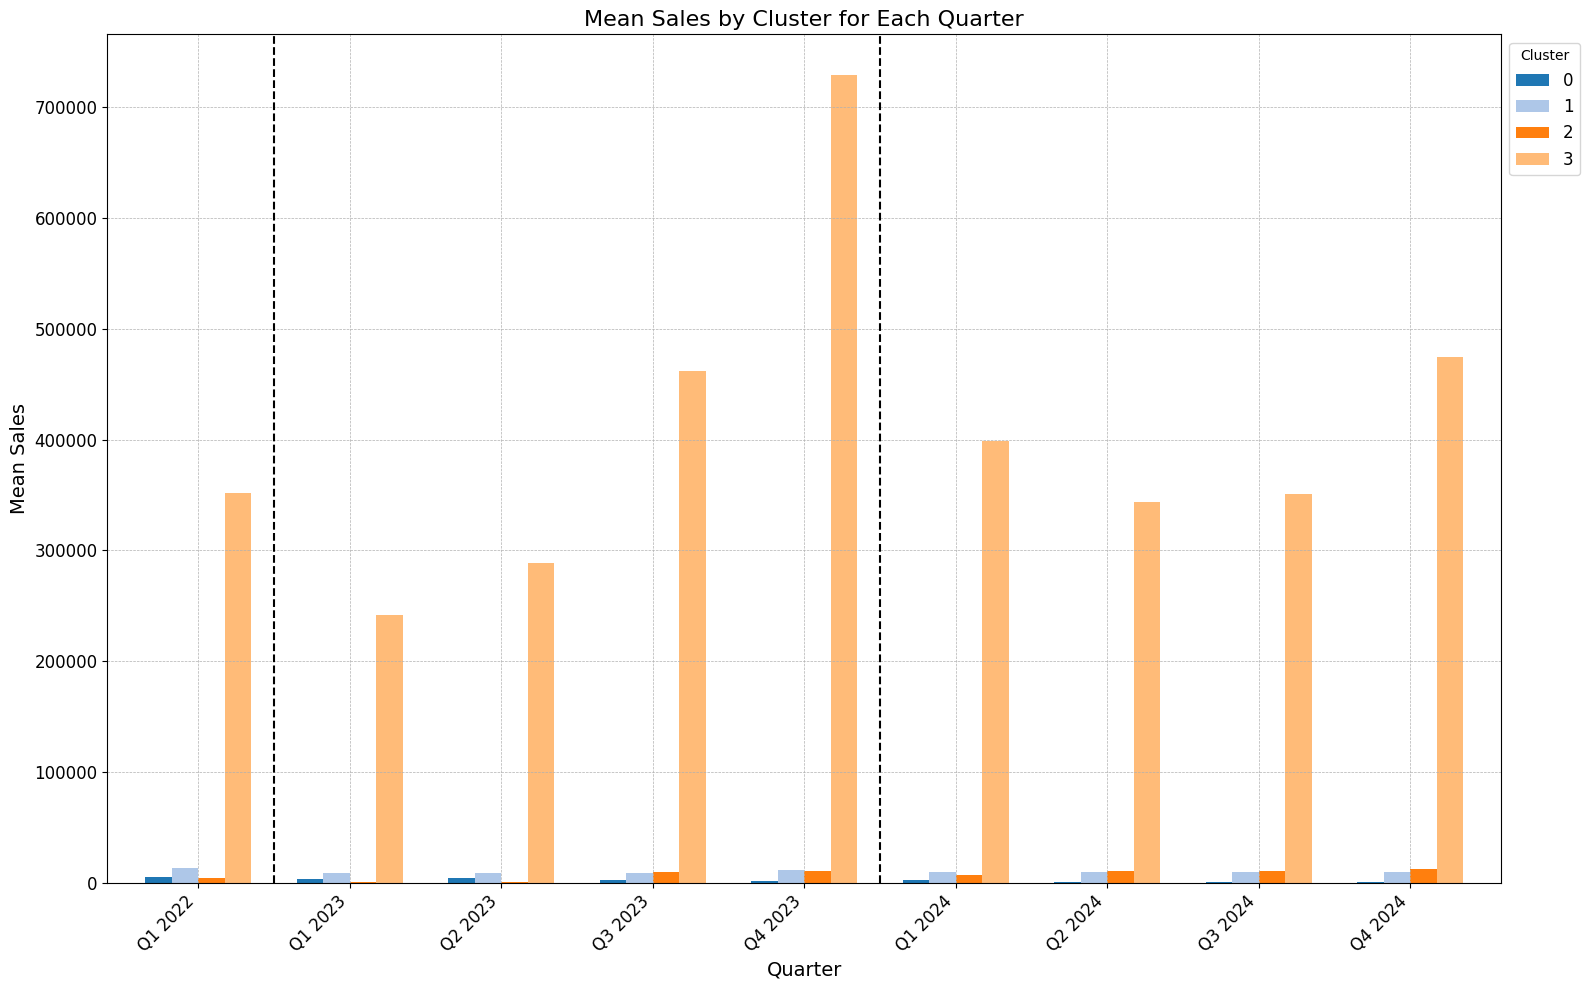

In [10]:

# Define the columns for each year with the updated column names
columns_by_year = {
    '2022': ['2022_Q_mean_sales_4'],
    '2023': ['2023_Q_mean_sales_1', '2023_Q_mean_sales_2', '2023_Q_mean_sales_3', '2023_Q_mean_sales_4'],
    '2024': ['2024_Q_mean_sales_1', '2024_Q_mean_sales_2', '2024_Q_mean_sales_3', '2024_Q_mean_sales_4']
}

# Concatenate the data for all years
plot_data = pd.DataFrame()
for year, columns in columns_by_year.items():
    cluster_means_year = cluster_means[columns]
    cluster_means_year.columns = [f'{year}_Q{i+1}' for i in range(len(columns))]
    plot_data = pd.concat([plot_data, cluster_means_year], axis=1)

# Transpose the data for plotting
plot_data = plot_data.T

# Create a DataFrame suitable for plotting
plot_data.index = [col.split('_')[1] + ' ' + col.split('_')[0] for col in plot_data.index]  # Extract the quarter and year information

# Define a consistent color palette
color_palette = sns.color_palette('tab20', n_colors=plot_data.shape[1])

# Create a color mapping for each cluster
cluster_colors = {cluster: color for cluster, color in zip(cluster_means.index, color_palette)}

# Plot the bar plot
fig, ax = plt.subplots(figsize=(16, 10))
plot_data.plot(kind='bar', ax=ax, width=0.7, color=[cluster_colors[cluster] for cluster in cluster_means.index])

# Add vertical lines to separate the years
year_end_2022 = len(columns_by_year['2022'])
year_end_2023 = year_end_2022 + len(columns_by_year['2023'])
plt.axvline(x=year_end_2022 - 0.5, color='black', linestyle='--')
plt.axvline(x=year_end_2023 - 0.5, color='black', linestyle='--')

# Set the labels and title
ax.set_xlabel('Quarter', fontsize=14)
ax.set_ylabel('Mean Sales', fontsize=14)
ax.set_title('Mean Sales by Cluster for Each Quarter', fontsize=16)
ax.legend(title='Cluster', fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xticklabels(plot_data.index, rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

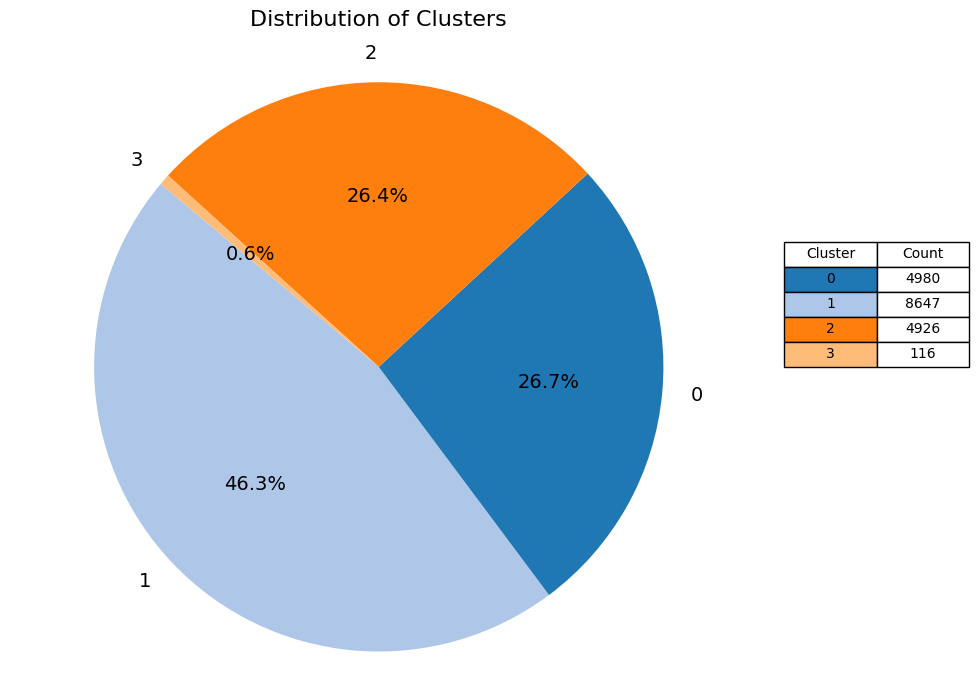

In [11]:
# Get the value counts for the 'cluster' column
cluster_counts = all_metrics['cluster'].value_counts()

# Plot the pie chart
fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=[cluster_colors[cluster] for cluster in cluster_counts.index], textprops={'fontsize': 14})
ax.set_title('Distribution of Clusters', fontsize=16, pad=20, loc='center')  # Center the title
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a table with the cluster counts in the top right corner
table_data = cluster_counts.reset_index()
table_data.columns = ['Cluster', 'Count']
table_data = table_data.sort_values(by='Cluster')  # Sort the table data by 'Cluster'

# Create cell colors based on the cluster colors
cell_colors = [[cluster_colors[cluster], 'white'] for cluster in table_data['Cluster']]

table = plt.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='upper right', bbox=[1.05, 0.5, 0.25, 0.2], cellColours=cell_colors)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(0.8, 0.8)  # Make the table smaller

# Show the plot
plt.tight_layout()
plt.show()

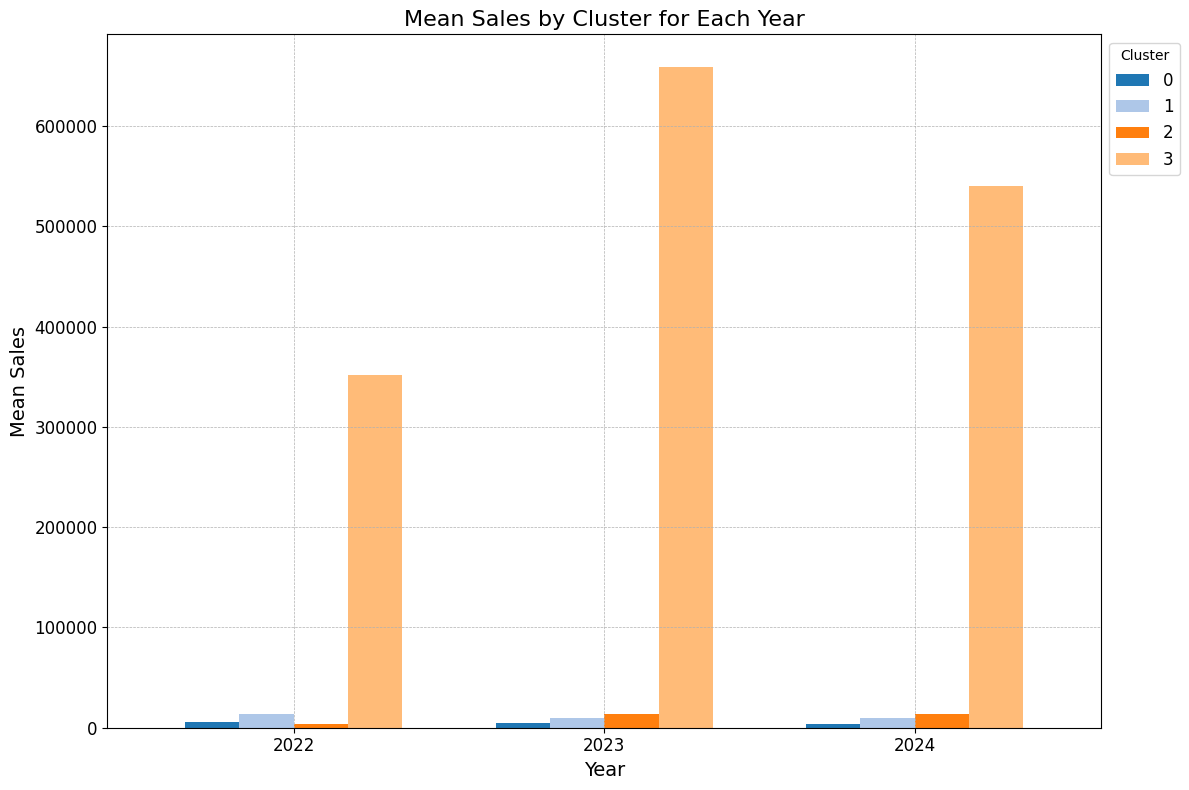

In [12]:
# Define the columns for the years
columns_years = ['2022_year_mean_sales', '2023_year_mean_sales', '2024_year_mean_sales']

# Filter the cluster_means DataFrame to include only the columns for the years
cluster_means_years = cluster_means[columns_years]

# Transpose the data for plotting
plot_data_years = cluster_means_years.T

# Create a DataFrame suitable for plotting
plot_data_years.index = ['2022', '2023', '2024']  # Set the index to the years

# Define a consistent color palette
color_palette = sns.color_palette('tab20', n_colors=plot_data_years.shape[1])


# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
plot_data_years.plot(kind='bar', ax=ax, width=0.7, color=color_palette)

# Set the labels and title
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Mean Sales', fontsize=14)
ax.set_title('Mean Sales by Cluster for Each Year', fontsize=16)
ax.legend(title='Cluster', fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xticklabels(plot_data_years.index, rotation=0, fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

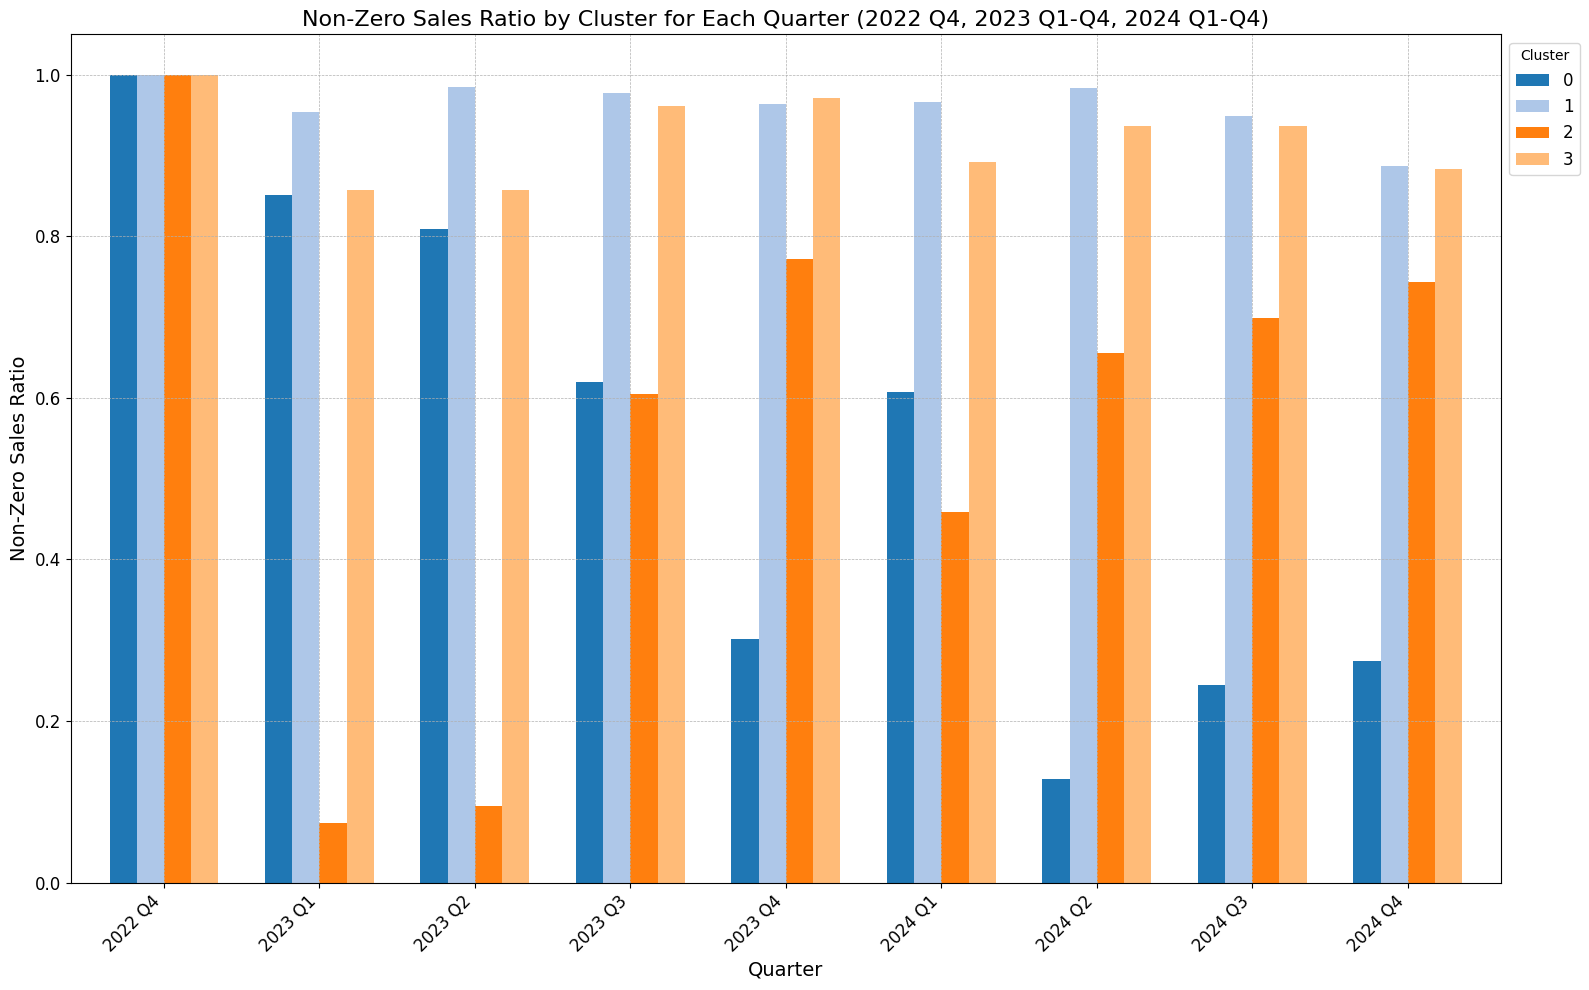

In [13]:

# Define the columns for the non-zero sales ratio
columns_non_zero_sales_ratio = [
    '2022_Q_non_zero_sales_ratio_4',
    '2023_Q_non_zero_sales_ratio_1',
    '2023_Q_non_zero_sales_ratio_2',
    '2023_Q_non_zero_sales_ratio_3',
    '2023_Q_non_zero_sales_ratio_4',
    '2024_Q_non_zero_sales_ratio_1',
    '2024_Q_non_zero_sales_ratio_2',
    '2024_Q_non_zero_sales_ratio_3',
    '2024_Q_non_zero_sales_ratio_4'
]

# Filter the cluster_means DataFrame to include only the specified columns
cluster_means_non_zero_sales_ratio = cluster_means[columns_non_zero_sales_ratio]

# Transpose the data for plotting
plot_data_non_zero_sales_ratio = cluster_means_non_zero_sales_ratio.T

# Create a DataFrame suitable for plotting
plot_data_non_zero_sales_ratio.index = [
    '2022 Q4',
    '2023 Q1',
    '2023 Q2',
    '2023 Q3',
    '2023 Q4',
    '2024 Q1',
    '2024 Q2',
    '2024 Q3',
    '2024 Q4'
]  # Set the index to the quarters

# Define a consistent color palette
color_palette = sns.color_palette('tab20', n_colors=plot_data_non_zero_sales_ratio.shape[1])

# Plot the data
fig, ax = plt.subplots(figsize=(16, 10))
plot_data_non_zero_sales_ratio.plot(kind='bar', ax=ax, width=0.7, color=color_palette)

# Set the labels and title
ax.set_xlabel('Quarter', fontsize=14)
ax.set_ylabel('Non-Zero Sales Ratio', fontsize=14)
ax.set_title('Non-Zero Sales Ratio by Cluster for Each Quarter (2022 Q4, 2023 Q1-Q4, 2024 Q1-Q4)', fontsize=16)
ax.legend(title='Cluster', fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xticklabels(plot_data_non_zero_sales_ratio.index, rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
all_metrics

,pdv_codigo,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2022_Q_non_zero_sales_ratio_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2023_Q_non_zero_sales_ratio_1,2023_Q_non_zero_sales_ratio_2,2023_Q_non_zero_sales_ratio_3,2023_Q_non_zero_sales_ratio_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4,2024_Q_non_zero_sales_ratio_1,2024_Q_non_zero_sales_ratio_2,2024_Q_non_zero_sales_ratio_3,2024_Q_non_zero_sales_ratio_4,cluster
0,1,78905351,3600.0,3600.0,1.0,2567.8,1632.0,3600.0,2400.0,2491.3,1.0,1.0,1.0,1.0,2645.5,2680.0,2502.9,2500.0,3000.0,1.0,1.0,1.0,1.0,1
1,1,78905498,5462.1,5462.1,1.0,6067.6,6900.0,5716.7,5767.3,5640.0,1.0,1.0,1.0,1.0,3762.2,3720.0,3771.4,4000.0,3463.6,1.0,1.0,1.0,1.0,1
2,1,78908901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6623.5,0.0,0.0,0.0,6623.5,0.0,0.0,0.0,1.0,2
3,1,78909045,11566.7,11566.7,1.0,9538.0,12373.6,8667.6,8747.3,8422.2,1.0,1.0,1.0,1.0,9129.6,7332.4,5395.0,13321.0,0.0,1.0,1.0,1.0,0.0,1
4,1,78912939,16108.3,16108.3,1.0,12593.0,17778.1,10489.0,10472.8,11769.2,1.0,1.0,1.0,1.0,8363.9,8378.5,5724.4,9827.2,8562.5,1.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18664,30,8412598003370,3960.0,3960.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980.0,0.0,1980.0,0.0,0.0,0.0,1.0,0.0,0.0,2
18665,30,8412598034213,NaN,NaN,NaN,2121.4,825.0,2985.7,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
18666,30,8712000025649,62500.0,62500.0,1.0,21577.4,13800.0,36562.5,13300.0,25750.0,1.0,1.0,1.0,1.0,16754.4,18235.3,11704.5,18333.3,19027.8,1.0,1.0,1.0,1.0,1
18667,30,17898915949190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5676.0,5676.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2


In [16]:
all_metrics.shape

(18669, 24)

In [17]:
features.shape

(3939154, 29)

In [19]:
features = features.merge(all_metrics[['pdv_codigo', 'codigo_barras_sku','cluster']], on=['pdv_codigo', 'codigo_barras_sku'], how='left')
features.shape

(3939154, 30)

In [21]:
# saving the parquet file with the cluster info
features.to_parquet('../features/processed/features.parquet')

# Clustering by product

In [4]:
features = pd.read_parquet('../features/processed/cleaned_features.parquet')

In [90]:
features.drop(columns=['cluster_sku'], inplace=True)

In [5]:
import pandas as pd

all_metrics = pd.DataFrame()

for year in features['year'].unique():
    year_data = features[features['year'] == year]
    
    # Metrics by year
    yearly_metrics = year_data.groupby(['codigo_barras_sku'])['cant_vta'].agg(
        # total_sales='sum',
        mean_sales='mean',
        # sales_std='std',
        # max_sales='max',
        # min_sales='min',
        # zero_sales_days=lambda x: (x == 0).sum(),
        # non_zero_sales_ratio=lambda x: (x > 0).mean()
    ).reset_index()
    yearly_metrics = yearly_metrics.rename(columns=lambda col: f'{year}_year_{col}' if col not in ['codigo_barras_sku'] else col)
    
    # Metrics by quarter
    quarterly_metrics = year_data.groupby(['codigo_barras_sku', 'quarter'])['cant_vta'].agg(
        # total_sales='sum',
        mean_sales='mean',
        # sales_std='std',
        # max_sales='max',
        # min_sales='min',
        # zero_sales_days=lambda x: (x == 0).sum(),
        non_zero_sales_ratio=lambda x: (x > 0).mean()
    ).unstack('quarter', fill_value=0)
    quarterly_metrics.columns = [f'{year}_Q_{q}_{metric}' for q, metric in quarterly_metrics.columns]
    quarterly_metrics.reset_index(inplace=True)
    
    # # Metrics by month
    # monthly_metrics = year_data.groupby(['pdv_codigo', 'codigo_barras_sku', 'month'])['cant_vta'].agg(
    #     # total_sales='sum',
    #     mean_sales='mean',
    #     # sales_std='std',
    #     # max_sales='max',
    #     # min_sales='min',
    #     # zero_sales_days=lambda x: (x == 0).sum(),
    #     # non_zero_sales_ratio=lambda x: (x > 0).mean()
    # ).unstack('month', fill_value=0)
    # monthly_metrics.columns = [f'{year}_M_{m}_{metric}' for m, metric in monthly_metrics.columns]
    # monthly_metrics.reset_index(inplace=True)
    
    combined_metrics = yearly_metrics.merge(quarterly_metrics, on=['codigo_barras_sku'], how='outer')
    # combined_metrics = combined_metrics.merge(monthly_metrics, on=['pdv_codigo', 'codigo_barras_sku'], how='outer')

    combined_metrics = combined_metrics.apply(lambda x: x.round(1) if x.dtype == 'float64' else x)
    

    if all_metrics.empty:
        all_metrics = combined_metrics
    else:
        all_metrics = all_metrics.merge(combined_metrics, on=['codigo_barras_sku'], how='outer')

In [6]:
all_metrics.columns

Index(['codigo_barras_sku', '2022_year_mean_sales', '2022_Q_mean_sales_4',
       '2022_Q_non_zero_sales_ratio_4', '2023_year_mean_sales',
       '2023_Q_mean_sales_1', '2023_Q_mean_sales_2', '2023_Q_mean_sales_3',
       '2023_Q_mean_sales_4', '2023_Q_non_zero_sales_ratio_1',
       '2023_Q_non_zero_sales_ratio_2', '2023_Q_non_zero_sales_ratio_3',
       '2023_Q_non_zero_sales_ratio_4', '2024_year_mean_sales',
       '2024_Q_mean_sales_1', '2024_Q_mean_sales_2', '2024_Q_mean_sales_3',
       '2024_Q_mean_sales_4', '2024_Q_non_zero_sales_ratio_1',
       '2024_Q_non_zero_sales_ratio_2', '2024_Q_non_zero_sales_ratio_3',
       '2024_Q_non_zero_sales_ratio_4'],
      dtype='object')

In [7]:
all_metrics = all_metrics[['codigo_barras_sku', 
'2022_year_mean_sales', 
'2022_Q_mean_sales_4',
'2023_year_mean_sales',
'2023_Q_mean_sales_1', 
'2023_Q_mean_sales_2', 
'2023_Q_mean_sales_3',
'2023_Q_mean_sales_4', 
'2024_year_mean_sales',
'2024_Q_mean_sales_1', 
'2024_Q_mean_sales_2', 
'2024_Q_mean_sales_3',
'2024_Q_mean_sales_4'
]]
all_metrics

,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4
0,78908901,30134.4,30134.4,26229.0,26790.3,24571.5,24170.3,29412.5,38679.4,33516.8,33133.9,42775.1,45897.7
1,78933873,12689.3,12689.3,20663.6,13158.5,14273.1,21770.5,33320.8,43051.9,27653.4,29153.9,40149.3,79610.5
2,78936478,5940.7,5940.7,4643.0,5358.2,4932.9,4192.8,3815.0,5905.7,5071.5,5157.6,6371.0,6745.7
3,78936683,58234.4,58234.4,28813.1,34350.2,28006.0,24240.2,28999.2,27943.0,21845.2,25884.7,32200.4,32434.8
4,78937765,6949.2,6949.2,5761.1,6307.1,5296.0,5557.3,6017.0,4358.1,4504.1,3579.6,4504.9,4976.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,7898367983790,10139.1,10139.1,7392.5,6865.1,9291.7,6893.9,6748.3,9783.1,8214.4,8431.1,8826.4,13833.0
150,7898367984377,3920.0,3920.0,4017.9,3038.0,5028.2,3614.7,4027.5,6290.2,4205.5,5259.3,4786.4,11022.5
151,7898915949209,76860.3,76860.3,30714.5,42523.3,30365.3,23553.4,27927.8,20762.5,16853.4,23301.1,20978.9,21663.0
152,7898915949674,7000.0,7000.0,5569.8,6224.6,6771.2,4543.1,4556.7,11848.5,5454.9,4602.2,10998.9,23585.0


In [8]:
columns_to_check = [
    '2023_Q_mean_sales_1', 
    '2023_Q_mean_sales_2', 
    '2023_Q_mean_sales_3',
    '2023_Q_mean_sales_4', 
    '2024_Q_mean_sales_1',
    '2024_Q_mean_sales_2',    
    '2024_Q_mean_sales_3', 
    '2024_Q_mean_sales_4']

# Check for 0 or NaN values
mask = (all_metrics[columns_to_check] == 0) | (all_metrics[columns_to_check].isna())

rows_to_remove = mask.any(axis=1)
all_metrics = all_metrics[~rows_to_remove] 
all_metrics

,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4
0,78908901,30134.4,30134.4,26229.0,26790.3,24571.5,24170.3,29412.5,38679.4,33516.8,33133.9,42775.1,45897.7
1,78933873,12689.3,12689.3,20663.6,13158.5,14273.1,21770.5,33320.8,43051.9,27653.4,29153.9,40149.3,79610.5
2,78936478,5940.7,5940.7,4643.0,5358.2,4932.9,4192.8,3815.0,5905.7,5071.5,5157.6,6371.0,6745.7
3,78936683,58234.4,58234.4,28813.1,34350.2,28006.0,24240.2,28999.2,27943.0,21845.2,25884.7,32200.4,32434.8
4,78937765,6949.2,6949.2,5761.1,6307.1,5296.0,5557.3,6017.0,4358.1,4504.1,3579.6,4504.9,4976.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,7898367983790,10139.1,10139.1,7392.5,6865.1,9291.7,6893.9,6748.3,9783.1,8214.4,8431.1,8826.4,13833.0
150,7898367984377,3920.0,3920.0,4017.9,3038.0,5028.2,3614.7,4027.5,6290.2,4205.5,5259.3,4786.4,11022.5
151,7898915949209,76860.3,76860.3,30714.5,42523.3,30365.3,23553.4,27927.8,20762.5,16853.4,23301.1,20978.9,21663.0
152,7898915949674,7000.0,7000.0,5569.8,6224.6,6771.2,4543.1,4556.7,11848.5,5454.9,4602.2,10998.9,23585.0


In [12]:
filter = features[['codigo_barras_sku', 'cluster_sku']].drop_duplicates()
all_metrics = all_metrics.merge(filter, on=['codigo_barras_sku'], how='inner')
all_metrics

,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4,cluster_sku
0,78908901,30134.4,30134.4,26229.0,26790.3,24571.5,24170.3,29412.5,38679.4,33516.8,33133.9,42775.1,45897.7,2
1,78933873,12689.3,12689.3,20663.6,13158.5,14273.1,21770.5,33320.8,43051.9,27653.4,29153.9,40149.3,79610.5,2
2,78936478,5940.7,5940.7,4643.0,5358.2,4932.9,4192.8,3815.0,5905.7,5071.5,5157.6,6371.0,6745.7,0
3,78936683,58234.4,58234.4,28813.1,34350.2,28006.0,24240.2,28999.2,27943.0,21845.2,25884.7,32200.4,32434.8,2
4,78937765,6949.2,6949.2,5761.1,6307.1,5296.0,5557.3,6017.0,4358.1,4504.1,3579.6,4504.9,4976.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,7898367983790,10139.1,10139.1,7392.5,6865.1,9291.7,6893.9,6748.3,9783.1,8214.4,8431.1,8826.4,13833.0,0
150,7898367984377,3920.0,3920.0,4017.9,3038.0,5028.2,3614.7,4027.5,6290.2,4205.5,5259.3,4786.4,11022.5,0
151,7898915949209,76860.3,76860.3,30714.5,42523.3,30365.3,23553.4,27927.8,20762.5,16853.4,23301.1,20978.9,21663.0,2
152,7898915949674,7000.0,7000.0,5569.8,6224.6,6771.2,4543.1,4556.7,11848.5,5454.9,4602.2,10998.9,23585.0,0


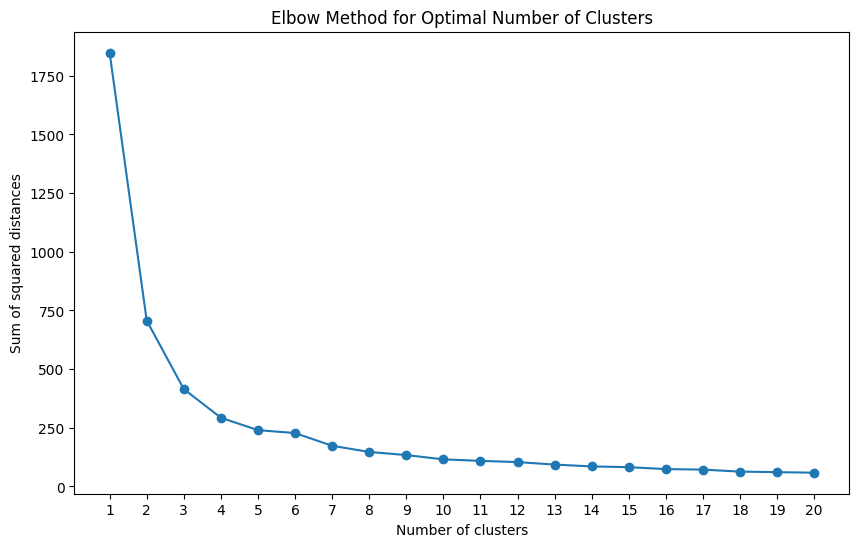

In [95]:
clustering_features = all_metrics.drop(columns=['codigo_barras_sku'])

# Handle missing values by filling with 0
clustering_features = clustering_features.fillna(0)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Elbow method to determine the ideal number of clusters
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, 21)) 
plt.show()

In [98]:
# Apply K-Means clustering with 8 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
all_metrics['cluster_sku'] = kmeans.fit_predict(scaled_features)

all_metrics['cluster_sku'].value_counts()
all_metrics

/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_14399/2653523166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_metrics['cluster_sku'] = kmeans.fit_predict(scaled_features)


,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4,cluster_sku
0,78908901,30134.4,30134.4,26229.0,26790.3,24571.5,24170.3,29412.5,38679.4,33516.8,33133.9,42775.1,45897.7,2
1,78933873,12689.3,12689.3,20663.6,13158.5,14273.1,21770.5,33320.8,43051.9,27653.4,29153.9,40149.3,79610.5,2
2,78936478,5940.7,5940.7,4643.0,5358.2,4932.9,4192.8,3815.0,5905.7,5071.5,5157.6,6371.0,6745.7,0
3,78936683,58234.4,58234.4,28813.1,34350.2,28006.0,24240.2,28999.2,27943.0,21845.2,25884.7,32200.4,32434.8,2
4,78937765,6949.2,6949.2,5761.1,6307.1,5296.0,5557.3,6017.0,4358.1,4504.1,3579.6,4504.9,4976.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,7898367983790,10139.1,10139.1,7392.5,6865.1,9291.7,6893.9,6748.3,9783.1,8214.4,8431.1,8826.4,13833.0,0
151,7898367984377,3920.0,3920.0,4017.9,3038.0,5028.2,3614.7,4027.5,6290.2,4205.5,5259.3,4786.4,11022.5,0
152,7898915949209,76860.3,76860.3,30714.5,42523.3,30365.3,23553.4,27927.8,20762.5,16853.4,23301.1,20978.9,21663.0,2
153,7898915949674,7000.0,7000.0,5569.8,6224.6,6771.2,4543.1,4556.7,11848.5,5454.9,4602.2,10998.9,23585.0,0


In [13]:
all_metrics['cluster_sku'].value_counts()

cluster_sku
0    100
2     41
1     13
Name: count, dtype: int64

In [46]:
# codigo_barras_to_remove = all_metrics[all_metrics['cluster_sku']== 2]['codigo_barras_sku'].unique()
# all_metrics = all_metrics[~all_metrics['codigo_barras_sku'].isin(codigo_barras_to_remove)]

In [14]:
all_metrics[all_metrics['cluster_sku']== 1]['2024_year_mean_sales'].mean()

86616.32307692307

In [101]:
features = features.merge(all_metrics[['codigo_barras_sku','cluster_sku']], on=['codigo_barras_sku'], how='inner')
features



,pdv_codigo,fecha_comercial,codigo_barras_sku,nombre_sku,imp_vta,cant_vta,stock,year,month,day,day_of_week,is_weekend,quarter,week_of_year,day_of_year,is_month_start,is_month_end,is_first_week,is_last_week,cluster,cluster_sku
0,1,2022-12-01,78936478,REFRIG FANTA LARANJA PET 200ML,5.96,800.0,NaN,2022,12,1,3,0,4,48,335,1,0,1,0,1,0
1,1,2022-12-02,78936478,REFRIG FANTA LARANJA PET 200ML,11.92,1600.0,NaN,2022,12,2,4,0,4,48,336,0,0,1,0,1,0
2,1,2022-12-04,78936478,REFRIG FANTA LARANJA PET 200ML,37.25,5000.0,NaN,2022,12,4,6,1,4,48,338,0,0,1,0,1,0
3,1,2022-12-05,78936478,REFRIG FANTA LARANJA PET 200ML,7.45,1000.0,NaN,2022,12,5,0,0,4,49,339,0,0,1,0,1,0
4,1,2022-12-06,78936478,REFRIG FANTA LARANJA PET 200ML,4.47,600.0,NaN,2022,12,6,1,0,4,49,340,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850893,30,2024-12-04,7897395099329,CERVEJA PETRA PURO MALTE LATA 350ML,11.96,1400.0,3077.0,2024,12,4,2,0,4,49,339,0,0,1,0,1,2
850894,30,2024-12-05,7897395099329,CERVEJA PETRA PURO MALTE LATA 350ML,201.23,26950.0,3077.0,2024,12,5,3,0,4,49,340,0,0,1,0,1,2
850895,30,2024-12-06,7897395099329,CERVEJA PETRA PURO MALTE LATA 350ML,727.08,102200.0,2668.0,2024,12,6,4,0,4,49,341,0,0,1,0,1,2
850896,30,2024-12-07,7897395099329,CERVEJA PETRA PURO MALTE LATA 350ML,83.72,9800.0,2616.0,2024,12,7,5,1,4,49,342,0,0,1,0,1,2


In [102]:
features['cluster_sku'].value_counts()

cluster_sku
0    425765
2    281854
1    143279
Name: count, dtype: int64

In [103]:
features['codigo_barras_sku'].nunique()

154

In [104]:
features.head()

,pdv_codigo,fecha_comercial,codigo_barras_sku,nombre_sku,imp_vta,cant_vta,stock,year,month,day,day_of_week,is_weekend,quarter,week_of_year,day_of_year,is_month_start,is_month_end,is_first_week,is_last_week,cluster,cluster_sku
0,1,2022-12-01,78936478,REFRIG FANTA LARANJA PET 200ML,5.96,800.0,NaN,2022,12,1,3,0,4,48,335,1,0,1,0,1,0
1,1,2022-12-02,78936478,REFRIG FANTA LARANJA PET 200ML,11.92,1600.0,NaN,2022,12,2,4,0,4,48,336,0,0,1,0,1,0
2,1,2022-12-04,78936478,REFRIG FANTA LARANJA PET 200ML,37.25,5000.0,NaN,2022,12,4,6,1,4,48,338,0,0,1,0,1,0
3,1,2022-12-05,78936478,REFRIG FANTA LARANJA PET 200ML,7.45,1000.0,NaN,2022,12,5,0,0,4,49,339,0,0,1,0,1,0
4,1,2022-12-06,78936478,REFRIG FANTA LARANJA PET 200ML,4.47,600.0,NaN,2022,12,6,1,0,4,49,340,0,0,1,0,1,0


In [15]:
cluster_means = all_metrics.groupby('cluster_sku').mean()
cluster_means

,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4
cluster_sku,,,,,,,,,,,,,
0,7.578678e+12,10156.352577,10156.352577,8273.546000,7604.459000,7091.741000,7525.476000,10855.751000,9901.955000,9889.841000,9366.424000,9612.924000,10839.878000
1,7.894374e+12,96778.346154,96778.346154,67449.415385,60775.400000,58338.646154,61634.823077,89250.492308,86616.323077,77057.500000,78047.476923,91315.200000,102441.415385
2,7.316694e+12,47955.875610,47955.875610,32101.348780,31221.014634,29594.085366,28871.319512,38930.656098,33846.970732,33099.187805,32072.607317,32675.995122,37289.300000


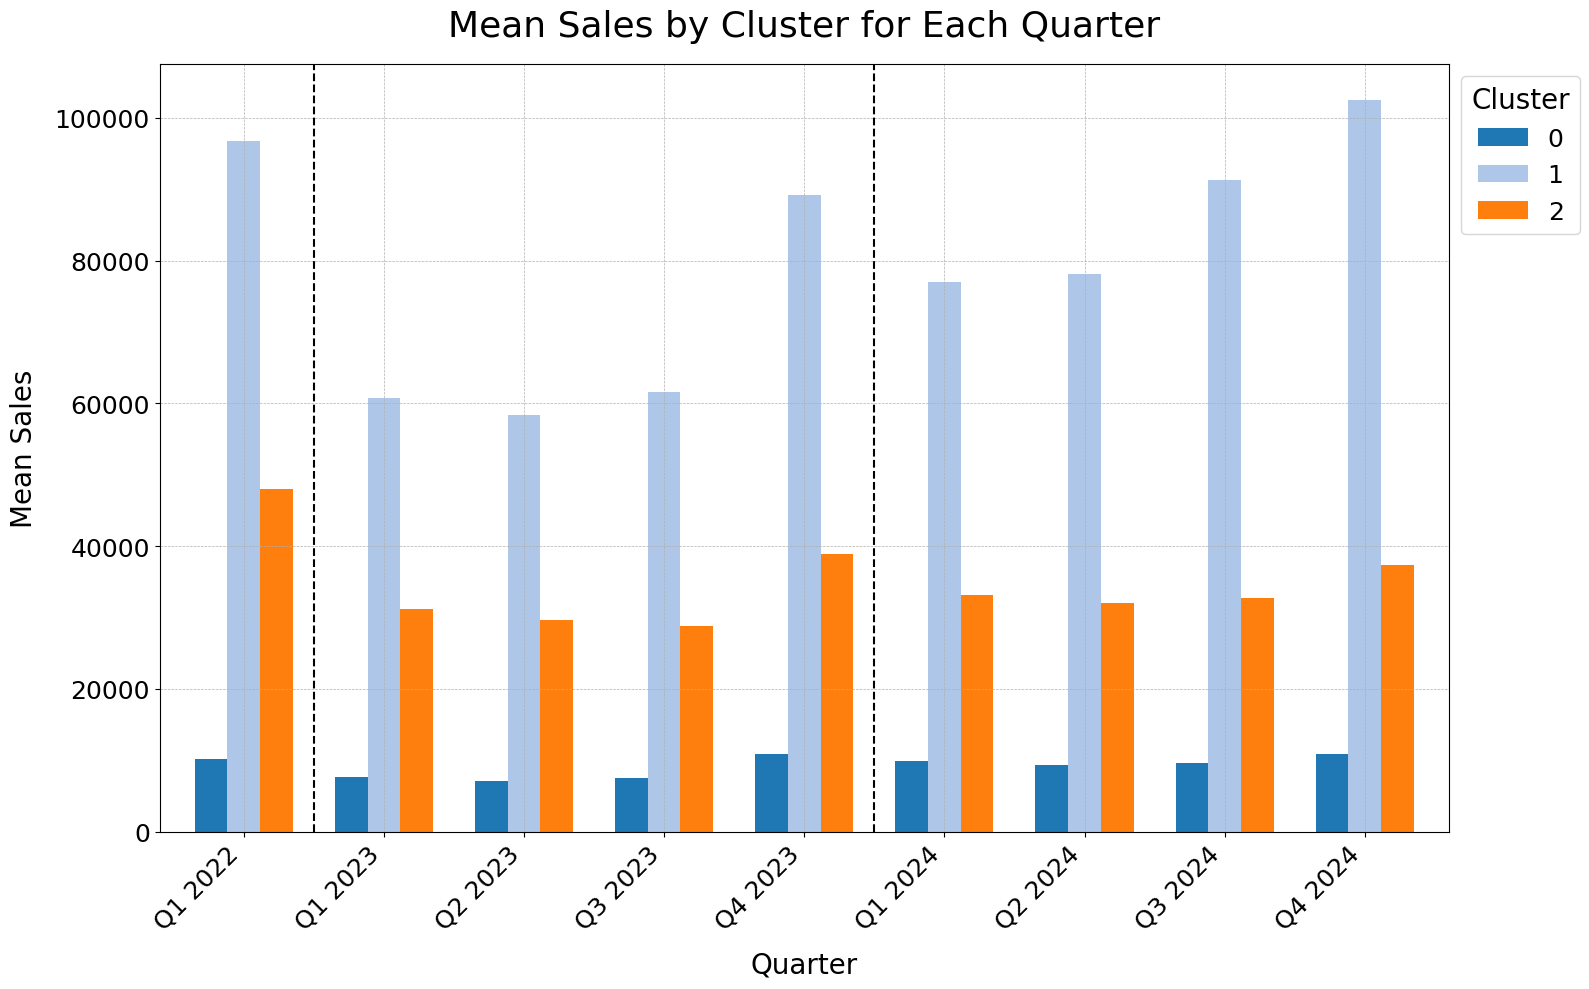

In [21]:

# Define the columns for each year with the updated column names
columns_by_year = {
    '2022': ['2022_Q_mean_sales_4'],
    '2023': ['2023_Q_mean_sales_1', '2023_Q_mean_sales_2', '2023_Q_mean_sales_3', '2023_Q_mean_sales_4'],
    '2024': ['2024_Q_mean_sales_1', '2024_Q_mean_sales_2', '2024_Q_mean_sales_3', '2024_Q_mean_sales_4']
}

# Concatenate the data for all years
plot_data = pd.DataFrame()
for year, columns in columns_by_year.items():
    cluster_means_year = cluster_means[columns]
    cluster_means_year.columns = [f'{year}_Q{i+1}' for i in range(len(columns))]
    plot_data = pd.concat([plot_data, cluster_means_year], axis=1)

# Transpose the data for plotting
plot_data = plot_data.T

# Create a DataFrame suitable for plotting
plot_data.index = [col.split('_')[1] + ' ' + col.split('_')[0] for col in plot_data.index]  # Extract the quarter and year information

# Define a consistent color palette
color_palette = sns.color_palette('tab20', n_colors=plot_data.shape[1])

# Create a color mapping for each cluster
cluster_colors = {cluster: color for cluster, color in zip(cluster_means.index, color_palette)}

# Plot the bar plot with big fonts
fig, ax = plt.subplots(figsize=(16, 10))
plot_data.plot(
    kind='bar',
    ax=ax,
    width=0.7,
    color=[cluster_colors[cluster] for cluster in cluster_means.index]
)

# Add vertical lines to separate the years
year_end_2022 = len(columns_by_year['2022'])
year_end_2023 = year_end_2022 + len(columns_by_year['2023'])
plt.axvline(x=year_end_2022 - 0.5, color='black', linestyle='--')
plt.axvline(x=year_end_2023 - 0.5, color='black', linestyle='--')

# Set the labels and title with BIGGER font sizes
ax.set_xlabel('Quarter', fontsize=20, labelpad=12)
ax.set_ylabel('Mean Sales', fontsize=20, labelpad=12)
ax.set_title('Mean Sales by Cluster for Each Quarter', fontsize=26, pad=20)

# Bigger tick labels
ax.set_xticklabels(plot_data.index, rotation=45, ha='right', fontsize=18)
ax.tick_params(axis='y', labelsize=18)

# Bigger legend title and labels
legend = ax.legend(
    title='Cluster',
    title_fontsize=20,
    fontsize=18,
    loc='upper left',
    bbox_to_anchor=(1, 1)
)

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


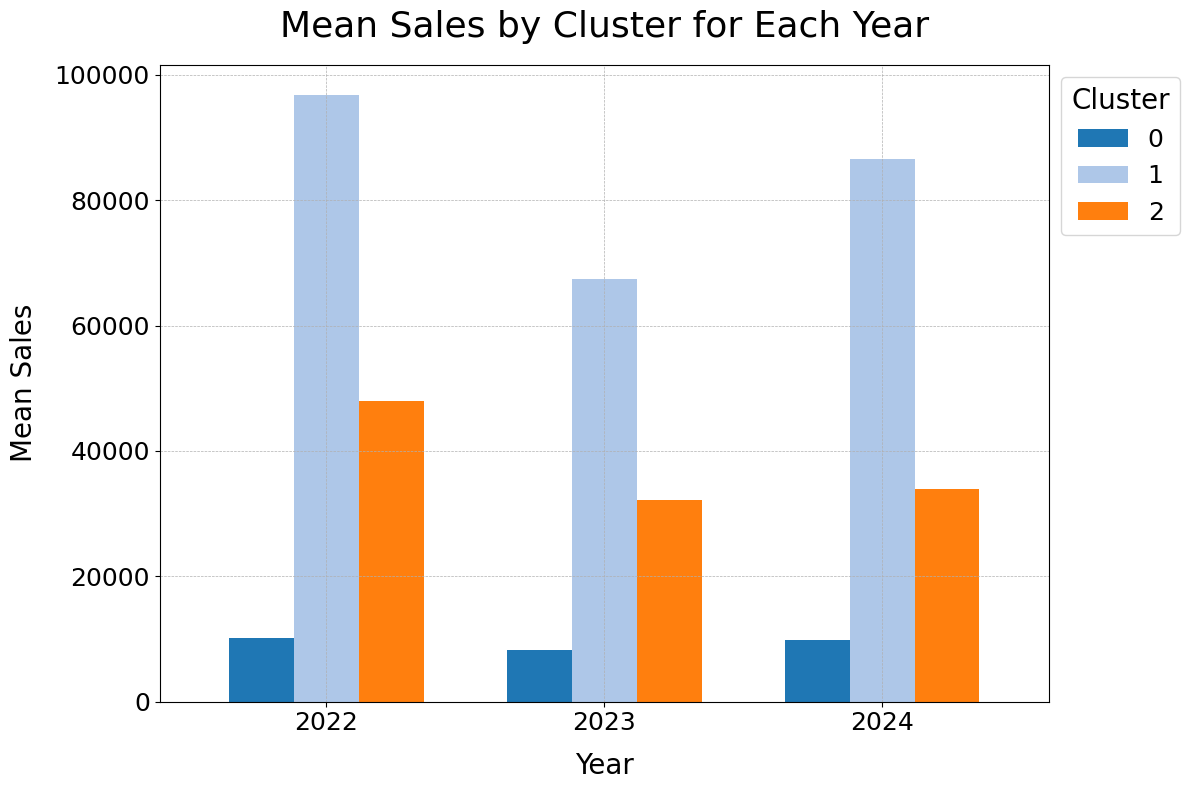

In [23]:
# Define the columns for the years
columns_years = ['2022_year_mean_sales', '2023_year_mean_sales', '2024_year_mean_sales']

# Filter the cluster_means DataFrame to include only the columns for the years
cluster_means_years = cluster_means[columns_years]

# Transpose the data for plotting
plot_data_years = cluster_means_years.T

# Create a DataFrame suitable for plotting
plot_data_years.index = ['2022', '2023', '2024']  # Set the index to the years

# Define a consistent color palette
color_palette = sns.color_palette('tab20', n_colors=plot_data_years.shape[1])


# Plot the data with BIGGER fonts
fig, ax = plt.subplots(figsize=(12, 8))
plot_data_years.plot(
    kind='bar',
    ax=ax,
    width=0.7,
    color=color_palette
)

# Set the labels and title with BIG FONT SIZES
ax.set_xlabel('Year', fontsize=20, labelpad=12)
ax.set_ylabel('Mean Sales', fontsize=20, labelpad=12)
ax.set_title('Mean Sales by Cluster for Each Year', fontsize=26, pad=20)

# Bigger ticks
ax.set_xticklabels(plot_data_years.index, rotation=0, fontsize=18)
ax.tick_params(axis='y', labelsize=18)

# Bigger legend
ax.legend(
    title='Cluster',
    title_fontsize=20,
    fontsize=18,
    loc='upper left',
    bbox_to_anchor=(1, 1)
)

# Grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


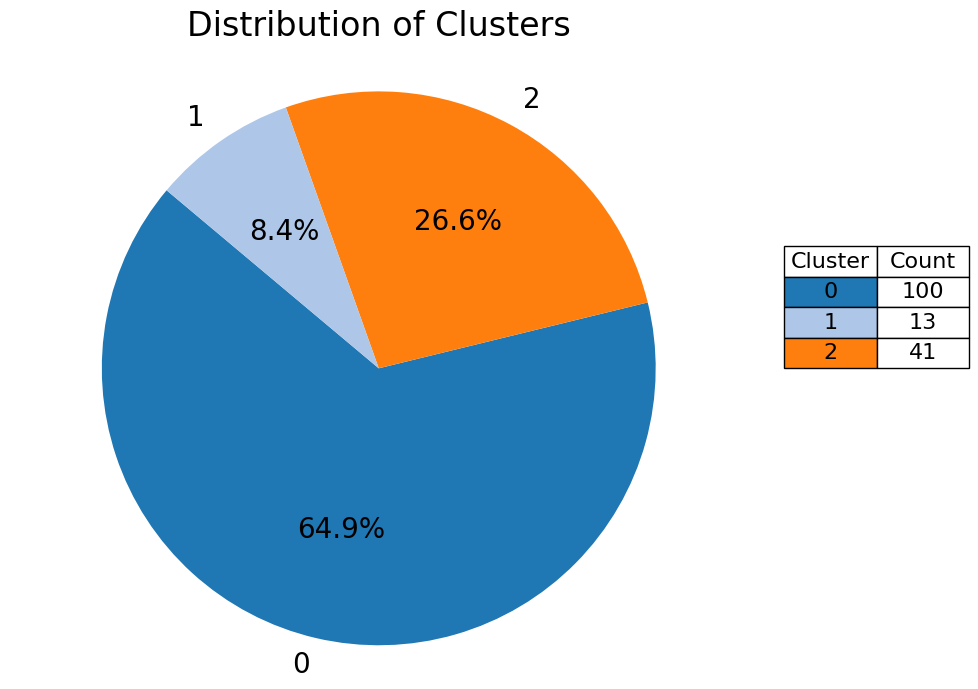

In [26]:
# Get the value counts for the 'cluster' column
cluster_counts = all_metrics['cluster_sku'].value_counts()

# Plot the pie chart
fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=[cluster_colors[cluster] for cluster in cluster_counts.index], textprops={'fontsize': 20})
ax.set_title('Distribution of Clusters', fontsize=24, pad=20, loc='center')  # Center the title
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a table with the cluster counts in the top right corner
table_data = cluster_counts.reset_index()
table_data.columns = ['Cluster', 'Count']
table_data = table_data.sort_values(by='Cluster')  # Sort the table data by 'Cluster'

# Create cell colors based on the cluster colors
cell_colors = [[cluster_colors[cluster], 'white'] for cluster in table_data['Cluster']]

table = plt.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='upper right', bbox=[1.05, 0.5, 0.25, 0.2], cellColours=cell_colors)
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(0.8, 0.8)  # Make the table smaller

# Show the plot
plt.tight_layout()
plt.show()

In [109]:
# saving the parquet file with the cluster info
features.to_parquet('../features/processed/cleaned_features.parquet')

# PCA

In [5]:
features = pd.read_parquet('../features/processed/cleaned_features.parquet')

In [6]:
import pandas as pd

all_metrics = pd.DataFrame()

for year in features['year'].unique():
    year_data = features[features['year'] == year]
    
    # Metrics by year
    yearly_metrics = year_data.groupby(['codigo_barras_sku'])['cant_vta'].agg(
        # total_sales='sum',
        mean_sales='mean',
        # sales_std='std',
        # max_sales='max',
        # min_sales='min',
        # zero_sales_days=lambda x: (x == 0).sum(),
        # non_zero_sales_ratio=lambda x: (x > 0).mean()
    ).reset_index()
    yearly_metrics = yearly_metrics.rename(columns=lambda col: f'{year}_year_{col}' if col not in ['codigo_barras_sku'] else col)
    
    # Metrics by quarter
    quarterly_metrics = year_data.groupby(['codigo_barras_sku', 'quarter'])['cant_vta'].agg(
        # total_sales='sum',
        mean_sales='mean',
        # sales_std='std',
        # max_sales='max',
        # min_sales='min',
        # zero_sales_days=lambda x: (x == 0).sum(),
        non_zero_sales_ratio=lambda x: (x > 0).mean()
    ).unstack('quarter', fill_value=0)
    quarterly_metrics.columns = [f'{year}_Q_{q}_{metric}' for q, metric in quarterly_metrics.columns]
    quarterly_metrics.reset_index(inplace=True)
    
    # # Metrics by month
    # monthly_metrics = year_data.groupby(['pdv_codigo', 'codigo_barras_sku', 'month'])['cant_vta'].agg(
    #     # total_sales='sum',
    #     mean_sales='mean',
    #     # sales_std='std',
    #     # max_sales='max',
    #     # min_sales='min',
    #     # zero_sales_days=lambda x: (x == 0).sum(),
    #     # non_zero_sales_ratio=lambda x: (x > 0).mean()
    # ).unstack('month', fill_value=0)
    # monthly_metrics.columns = [f'{year}_M_{m}_{metric}' for m, metric in monthly_metrics.columns]
    # monthly_metrics.reset_index(inplace=True)
    
    combined_metrics = yearly_metrics.merge(quarterly_metrics, on=['codigo_barras_sku'], how='outer')
    # combined_metrics = combined_metrics.merge(monthly_metrics, on=['pdv_codigo', 'codigo_barras_sku'], how='outer')

    combined_metrics = combined_metrics.apply(lambda x: x.round(1) if x.dtype == 'float64' else x)
    

    if all_metrics.empty:
        all_metrics = combined_metrics
    else:
        all_metrics = all_metrics.merge(combined_metrics, on=['codigo_barras_sku'], how='outer')

In [7]:
all_metrics = all_metrics[['codigo_barras_sku', 
'2022_year_mean_sales', 
'2022_Q_mean_sales_4',
'2023_year_mean_sales',
'2023_Q_mean_sales_1', 
'2023_Q_mean_sales_2', 
'2023_Q_mean_sales_3',
'2023_Q_mean_sales_4', 
'2024_year_mean_sales',
'2024_Q_mean_sales_1', 
'2024_Q_mean_sales_2', 
'2024_Q_mean_sales_3',
'2024_Q_mean_sales_4'
]]
all_metrics

,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4
0,78908901,30134.4,30134.4,26229.0,26790.3,24571.5,24170.3,29412.5,38679.4,33516.8,33133.9,42775.1,45897.7
1,78933873,12689.3,12689.3,20663.6,13158.5,14273.1,21770.5,33320.8,43051.9,27653.4,29153.9,40149.3,79610.5
2,78936478,5940.7,5940.7,4643.0,5358.2,4932.9,4192.8,3815.0,5905.7,5071.5,5157.6,6371.0,6745.7
3,78936683,58234.4,58234.4,28813.1,34350.2,28006.0,24240.2,28999.2,27943.0,21845.2,25884.7,32200.4,32434.8
4,78937765,6949.2,6949.2,5761.1,6307.1,5296.0,5557.3,6017.0,4358.1,4504.1,3579.6,4504.9,4976.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,7898367983790,10139.1,10139.1,7392.5,6865.1,9291.7,6893.9,6748.3,9783.1,8214.4,8431.1,8826.4,13833.0
150,7898367984377,3920.0,3920.0,4017.9,3038.0,5028.2,3614.7,4027.5,6290.2,4205.5,5259.3,4786.4,11022.5
151,7898915949209,76860.3,76860.3,30714.5,42523.3,30365.3,23553.4,27927.8,20762.5,16853.4,23301.1,20978.9,21663.0
152,7898915949674,7000.0,7000.0,5569.8,6224.6,6771.2,4543.1,4556.7,11848.5,5454.9,4602.2,10998.9,23585.0


In [8]:
columns_to_check = [
    '2023_Q_mean_sales_1', 
    '2023_Q_mean_sales_2', 
    '2023_Q_mean_sales_3',
    '2023_Q_mean_sales_4', 
    '2024_Q_mean_sales_1',
    '2024_Q_mean_sales_2',    
    '2024_Q_mean_sales_3', 
    '2024_Q_mean_sales_4']

# Check for 0 or NaN values
mask = (all_metrics[columns_to_check] == 0) | (all_metrics[columns_to_check].isna())

rows_to_remove = mask.any(axis=1)
all_metrics = all_metrics[~rows_to_remove] 
all_metrics

,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4
0,78908901,30134.4,30134.4,26229.0,26790.3,24571.5,24170.3,29412.5,38679.4,33516.8,33133.9,42775.1,45897.7
1,78933873,12689.3,12689.3,20663.6,13158.5,14273.1,21770.5,33320.8,43051.9,27653.4,29153.9,40149.3,79610.5
2,78936478,5940.7,5940.7,4643.0,5358.2,4932.9,4192.8,3815.0,5905.7,5071.5,5157.6,6371.0,6745.7
3,78936683,58234.4,58234.4,28813.1,34350.2,28006.0,24240.2,28999.2,27943.0,21845.2,25884.7,32200.4,32434.8
4,78937765,6949.2,6949.2,5761.1,6307.1,5296.0,5557.3,6017.0,4358.1,4504.1,3579.6,4504.9,4976.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,7898367983790,10139.1,10139.1,7392.5,6865.1,9291.7,6893.9,6748.3,9783.1,8214.4,8431.1,8826.4,13833.0
150,7898367984377,3920.0,3920.0,4017.9,3038.0,5028.2,3614.7,4027.5,6290.2,4205.5,5259.3,4786.4,11022.5
151,7898915949209,76860.3,76860.3,30714.5,42523.3,30365.3,23553.4,27927.8,20762.5,16853.4,23301.1,20978.9,21663.0
152,7898915949674,7000.0,7000.0,5569.8,6224.6,6771.2,4543.1,4556.7,11848.5,5454.9,4602.2,10998.9,23585.0


In [12]:
all_metrics

,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4
0,78908901,30134.4,30134.4,26229.0,26790.3,24571.5,24170.3,29412.5,38679.4,33516.8,33133.9,42775.1,45897.7
1,78933873,12689.3,12689.3,20663.6,13158.5,14273.1,21770.5,33320.8,43051.9,27653.4,29153.9,40149.3,79610.5
2,78936478,5940.7,5940.7,4643.0,5358.2,4932.9,4192.8,3815.0,5905.7,5071.5,5157.6,6371.0,6745.7
3,78936683,58234.4,58234.4,28813.1,34350.2,28006.0,24240.2,28999.2,27943.0,21845.2,25884.7,32200.4,32434.8
4,78937765,6949.2,6949.2,5761.1,6307.1,5296.0,5557.3,6017.0,4358.1,4504.1,3579.6,4504.9,4976.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,7898367983790,10139.1,10139.1,7392.5,6865.1,9291.7,6893.9,6748.3,9783.1,8214.4,8431.1,8826.4,13833.0
150,7898367984377,3920.0,3920.0,4017.9,3038.0,5028.2,3614.7,4027.5,6290.2,4205.5,5259.3,4786.4,11022.5
151,7898915949209,76860.3,76860.3,30714.5,42523.3,30365.3,23553.4,27927.8,20762.5,16853.4,23301.1,20978.9,21663.0
152,7898915949674,7000.0,7000.0,5569.8,6224.6,6771.2,4543.1,4556.7,11848.5,5454.9,4602.2,10998.9,23585.0


In [14]:
clusters = features[['codigo_barras_sku','cluster_sku']].drop_duplicates()
clusters

,codigo_barras_sku,cluster_sku
0,78936478,0
656,78936683,2
1389,78938571,0
2000,78939745,0
2618,7891149010509,2
...,...,...
659947,7896052603497,0
686699,7894900093056,0
758729,7891149108282,0
766861,7891991002646,0


In [16]:
data = all_metrics.merge(clusters, on=['codigo_barras_sku'], how='inner')
data

,codigo_barras_sku,2022_year_mean_sales,2022_Q_mean_sales_4,2023_year_mean_sales,2023_Q_mean_sales_1,2023_Q_mean_sales_2,2023_Q_mean_sales_3,2023_Q_mean_sales_4,2024_year_mean_sales,2024_Q_mean_sales_1,2024_Q_mean_sales_2,2024_Q_mean_sales_3,2024_Q_mean_sales_4,cluster_sku
0,78908901,30134.4,30134.4,26229.0,26790.3,24571.5,24170.3,29412.5,38679.4,33516.8,33133.9,42775.1,45897.7,2
1,78933873,12689.3,12689.3,20663.6,13158.5,14273.1,21770.5,33320.8,43051.9,27653.4,29153.9,40149.3,79610.5,2
2,78936478,5940.7,5940.7,4643.0,5358.2,4932.9,4192.8,3815.0,5905.7,5071.5,5157.6,6371.0,6745.7,0
3,78936683,58234.4,58234.4,28813.1,34350.2,28006.0,24240.2,28999.2,27943.0,21845.2,25884.7,32200.4,32434.8,2
4,78937765,6949.2,6949.2,5761.1,6307.1,5296.0,5557.3,6017.0,4358.1,4504.1,3579.6,4504.9,4976.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,7898367983790,10139.1,10139.1,7392.5,6865.1,9291.7,6893.9,6748.3,9783.1,8214.4,8431.1,8826.4,13833.0,0
150,7898367984377,3920.0,3920.0,4017.9,3038.0,5028.2,3614.7,4027.5,6290.2,4205.5,5259.3,4786.4,11022.5,0
151,7898915949209,76860.3,76860.3,30714.5,42523.3,30365.3,23553.4,27927.8,20762.5,16853.4,23301.1,20978.9,21663.0,2
152,7898915949674,7000.0,7000.0,5569.8,6224.6,6771.2,4543.1,4556.7,11848.5,5454.9,4602.2,10998.9,23585.0,0


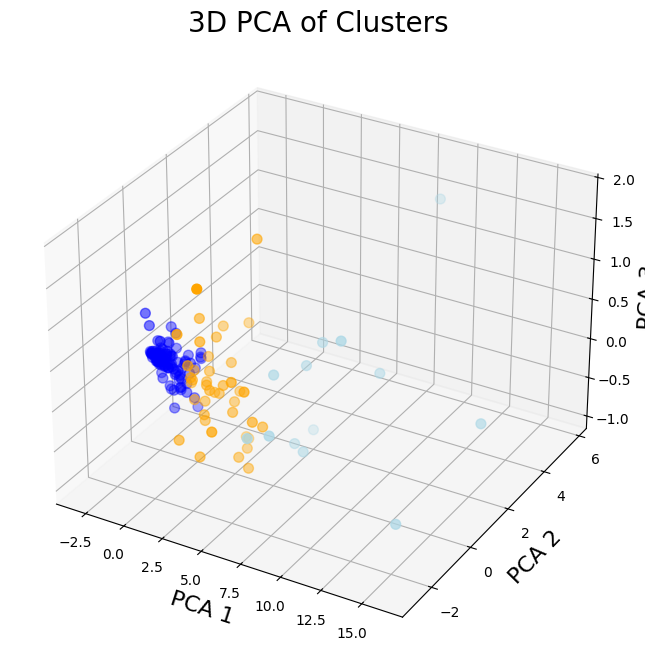

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'data' is your dataframe
features = ['2022_year_mean_sales', '2022_Q_mean_sales_4', '2023_year_mean_sales', 
            '2023_Q_mean_sales_1', '2023_Q_mean_sales_2', '2023_Q_mean_sales_3', 
            '2023_Q_mean_sales_4', '2024_year_mean_sales', '2024_Q_mean_sales_1', 
            '2024_Q_mean_sales_2', '2024_Q_mean_sales_3', '2024_Q_mean_sales_4']

# Extracting the feature columns
X = data[features]

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to reduce the data to 2 or 3 components
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_scaled)

# Adding PCA components to the dataframe
data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]
if X_pca.shape[1] > 2:
    data['PCA3'] = X_pca[:, 2]

# Define custom cluster colors
cluster_colors = {0: 'blue', 1: 'lightblue', 2: 'orange'}  

# Plotting the 2D or 3D PCA result
fig = plt.figure(figsize=(10, 8))

# 3D plot case
if X_pca.shape[1] == 2:
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data['PCA1'], data['PCA2'], data['PCA3'], 
               c=data['cluster_sku'].map(cluster_colors), s=50)
    ax.set_xlabel('PCA 1', fontsize=16)
    ax.set_ylabel('PCA 2', fontsize=16)
    ax.set_zlabel('PCA 3', fontsize=16)
    ax.set_title('3D PCA of Clusters', fontsize=20)
else:  # 2D plot case
    plt.scatter(data['PCA1'], data['PCA2'], 
                c=data['cluster_sku'].map(cluster_colors), s=50)
    plt.xlabel('PCA 1', fontsize=16)
    plt.ylabel('PCA 2', fontsize=16)
    plt.title('2D PCA of Clusters', fontsize=20)

# Show the plot
plt.show()
